# Разработка A/B-тестирования и анализ результатов

В рамках разработки A/B-тестирования для оценки нового алгоритма рекомендаций в развлекательном приложении с функцией «бесконечной» ленты, предлагаются две модели монетизации: ежемесячная платная подписка для просмотра без рекламы и бесплатный доступ с показом рекламы для неподписанных пользователей.

Необходимо рассчитать параметры A/B-теста, который позволит проверить эффективность нового алгоритма рекомендаций. Тестирование должно определить, способен ли новый алгоритм предоставлять пользователям более качественный и интересный контент. Важным аспектом является анализ полученных результатов тестирования для формирования обоснованных выводов и рекомендаций по развитию продукта.

## Описание данных

3 таблицы:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-15 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `/datasets/sessions_project_test_part.csv`.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).



**Задачи:** рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

После внедрения нового алгоритма рекомендации мы ожидаем увидеть рост среднего количества просматриваемых страниц на сеанс минимум на 10%, повышение конверсии в премиум-аккаунт хотя бы на 5% и снижение оттока пользователей благодаря повышению уровня удовлетворенности контентом.

### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных
На первом этапе поработайте с историческими данными приложения:

- Импортируйте библиотеку pandas.

- Считайте и сохраните в датафрейм `sessions_history` CSV-файл с историческими данными о сессиях пользователей `sessions_project_history.csv`.

Выведите на экран первые пять строк полученного датафрейма.

In [1]:
# загружаем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil
import seaborn as sns
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest

In [2]:
# Загрузка файла напрямую из интернета
sessions_history = pd.read_csv(r'https://code.s3.yandex.net/datasets/sessions_project_history.csv')

display(sessions_history.head())
display(sessions_history.info())

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435924 entries, 0 to 435923
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   user_id            435924 non-null  object
 1   session_id         435924 non-null  object
 2   session_date       435924 non-null  object
 3   session_start_ts   435924 non-null  object
 4   install_date       435924 non-null  object
 5   session_number     435924 non-null  int64 
 6   registration_flag  435924 non-null  int64 
 7   page_counter       435924 non-null  int64 
 8   region             435924 non-null  object
 9   device             435924 non-null  object
dtypes: int64(3), object(7)
memory usage: 33.3+ MB


None

#### 1.2. Знакомство с данными
- Для каждого уникального пользователя `user_id` рассчитайте количество уникальных сессий `session_id`.

- Выведите на экран все данные из таблицы `sessions_history` для одного пользователя с наибольшим количеством сессий. Если таких пользователей несколько, выберите любого из них.

- Изучите таблицу для одного пользователя, чтобы лучше понять логику формирования каждого столбца данных.



In [3]:
# Подсчёт уникальных сессий для каждого пользователя
unique_sessions_per_user = sessions_history.groupby('user_id')['session_id'].nunique().reset_index()

# Выбор пользователя с наибольшим количеством сессий
max_session_user = unique_sessions_per_user.sort_values(by='session_id', ascending=False)['user_id'].iloc[0]

# Фильтрация данных по пользователю с максимальным количеством сессий
selected_user_data = sessions_history.query('user_id == @max_session_user')

# Выводим всю информацию по данному пользователю
display(selected_user_data)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


#### 1.3. Анализ числа регистраций

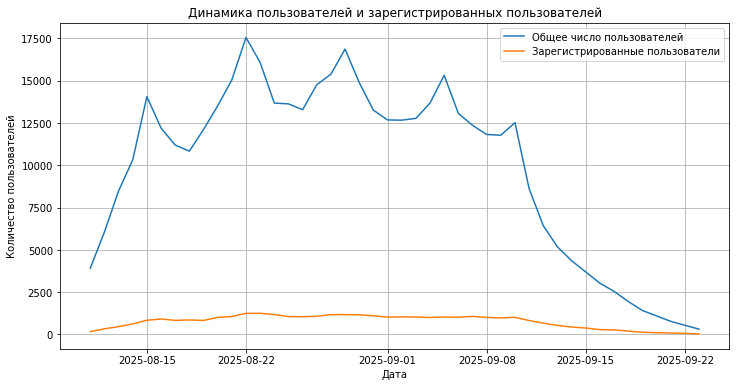

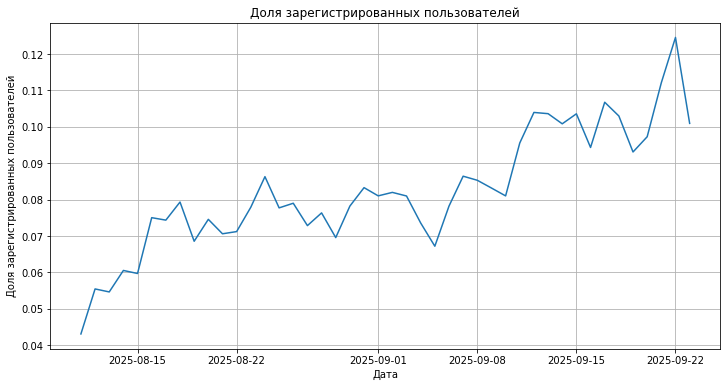

In [4]:
# Преобразовываем строки с датами в объекты datetime
sessions_history['session_date'] = pd.to_datetime(sessions_history['session_date'])

# Агрегация данных: считаем уникальных пользователей и зарегистрированных пользователей по дням
aggregated_data = sessions_history.groupby('session_date').agg({
    'user_id': 'nunique',          # Уникальные пользователи
    'registration_flag': 'sum'     # Зарегистрированные пользователи (суммируем True/False как 1/0)
}).rename(columns={
    'user_id': 'total_users',
    'registration_flag': 'registered_users'
})

# Добавляем долю зарегистрированных пользователей
aggregated_data['share_registered'] = aggregated_data['registered_users'] / aggregated_data['total_users']

# Построение первого графика: общий тренд пользователей и зарегистрированных пользователей
plt.figure(figsize=(12, 6))  # Размер графика
plt.plot(aggregated_data.index, aggregated_data['total_users'], label='Общее число пользователей')
plt.plot(aggregated_data.index, aggregated_data['registered_users'], label='Зарегистрированные пользователи')
plt.title('Динамика пользователей и зарегистрированных пользователей')
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')
plt.grid(True)
plt.legend()
plt.show()

# Построение второго графика: доля зарегистрированных пользователей
plt.figure(figsize=(12, 6))
plt.plot(aggregated_data.index, aggregated_data['share_registered'])
plt.title('Доля зарегистрированных пользователей')
plt.xlabel('Дата')
plt.ylabel('Доля зарегистрированных пользователей')
plt.grid(True)
plt.show()

**ГРАФИК 1:** Динамика пользователей и зарегистрированных пользователей

Общее количество пользователей демонстрирует ярко выраженный рост с начала периода до конца августа, достигая пика около 17 500 пользователей. После этого наблюдается устойчивое снижение.
Число зарегистрированных пользователей увеличивается более умеренными темпами и варьируется от около 500 до 2 000. Видим небольшие колебания, но без резких скачков.
С 10 сентября начинается постепенное снижение как общего количества, так и числа зарегистрированных пользователей, что может говорить о спаде активности или завершении рекламной кампании.

**ГРАФИК 2:** Доля зарегистрированных пользователей

Доля зарегистрированных пользователей возросла с ~4.5% до более 12%, что говорит об улучшении конверсии — несмотря на общее падение числа пользователей, качество трафика увеличилось.
На протяжении всего периода доля демонстрирует положительный тренд с умеренной волатильностью, что может указывать на более эффективные механизмы привлечения и удержания зарегистрированных пользователей.

**ОСНОВНЫЕ ВЫВОДЫ:**
В августе наблюдается пик активности, за которым следует устойчивый спад.
Регистрации остаются относительно стабильными, несмотря на снижение общего трафика.
Конверсия в регистрацию улучшается, особенно в сентябре, что является положительным сигналом.

#### 1.4. Анализ числа просмотренных страниц
Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы на то, что он зарегистрируется и оплатит подписку.

- Найдите количество сессий для каждого значения количества просмотренных страниц. Например: одну страницу просмотрели в 29160 сессиях, две страницы в 105536 сессиях и так далее.

- Постройте столбчатую диаграмму, где по оси X будет число просмотренных страниц, по оси Y — количество сессий.

- На диаграмме должны быть заголовок, подписанные оси X и Y.

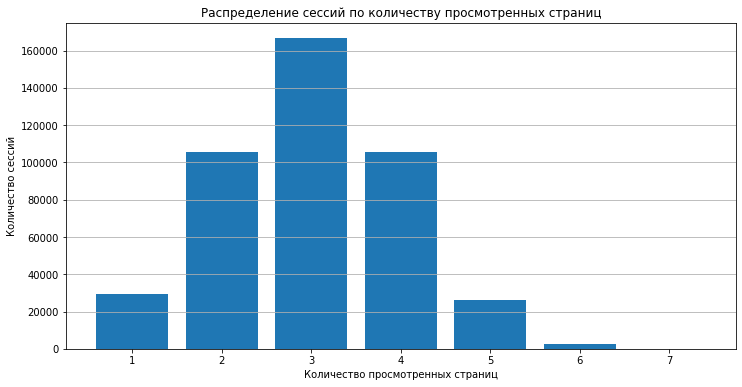

In [5]:
# Группировка данных по количеству просмотренных страниц и подсчет количества сессий
pages_count = sessions_history.groupby('page_counter')['session_id'].count().reset_index()
pages_count.columns = ['Просмотренные страницы', 'Количество сессий']

# Построение столбчатой диаграммы
plt.figure(figsize=(12, 6))
plt.bar(pages_count['Просмотренные страницы'], pages_count['Количество сессий'])
plt.title('Распределение сессий по количеству просмотренных страниц')
plt.xlabel('Количество просмотренных страниц')
plt.ylabel('Количество сессий')
plt.grid(axis='y')
plt.show()

#### 1.5. Доля пользователей, просмотревших более четырёх страниц

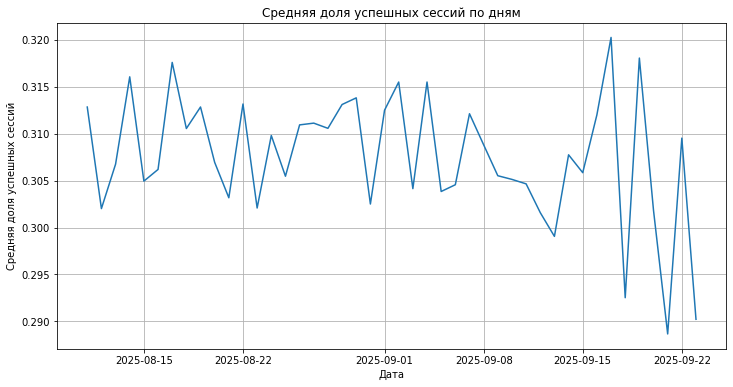

In [6]:
# Создаем новый столбец good_session, равный 1, если просмотрено >= 4 страниц, иначе 0
sessions_history['good_session'] = (sessions_history['page_counter'] >= 4).astype(int)

# Группируем данные по датам и рассчитываем среднюю долю хороших сессий
average_good_sessions_by_day = sessions_history.groupby('session_date')['good_session'].mean()

# Строим график средней доли удачных сессий по дням
plt.figure(figsize=(12, 6))
plt.plot(average_good_sessions_by_day.index, average_good_sessions_by_day.values)
plt.title('Средняя доля успешных сессий по дням')
plt.xlabel('Дата')
plt.ylabel('Средняя доля успешных сессий')
plt.grid(True)
plt.show()

### 2. Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Определиться с целевой метрикой.

- Рассчитать необходимый размер выборки.

- Исходя из текущих значений трафика, рассчитать необходимую длительность проведения теста.

#### 2.1. Расчёт размера выборки

In [7]:
from statsmodels.stats.power import NormalIndPower

# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 0.8  # Мощность теста
mde = 0.03  # Минимальный детектируемый эффект

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = mde,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 17441


#### 2.1. Расчёт длительности A/B-теста

Используйте данные о количестве пользователей в каждой выборке и среднем количестве пользователей приложения. Рассчитайте длительность теста, разделив одно на другое.

- Рассчитайте среднее количество уникальных пользователей приложения в день.

- Определите длительность теста, исходя из рассчитанного значения размера выборок и среднего дневного трафика приложения. Количество дней округлите в большую сторону.

In [8]:
# Определяем количество уникальных пользователей в день
daily_unique_users = sessions_history.groupby('session_date')['user_id'].nunique()

# Средний дневной трафик (среднее количество уникальных пользователей в день)
avg_daily_users = daily_unique_users.mean()

print(f"Среднее количество уникальных пользователей в день: {avg_daily_users:.2f}")

Среднее количество уникальных пользователей в день: 9907.36


In [9]:
# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = 9907

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil((sample_size*2)/avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907 пользователей в день составит 4 дней


### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

In [10]:
sessions_test_part = pd.read_csv(r'https://code.s3.yandex.net/datasets/sessions_project_test_part.csv')

test_group
A    1477
B    1466
Name: user_id, dtype: int64
Процентная разница в количестве пользователей между группами: 0.74%


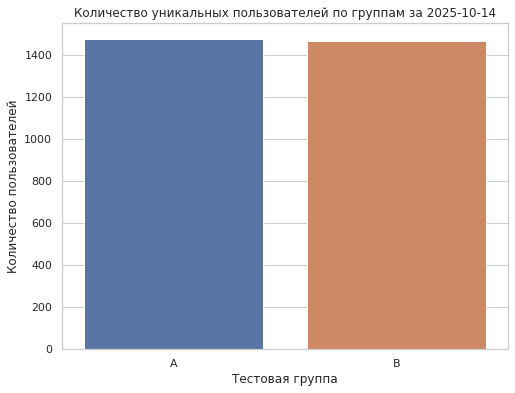

In [11]:
# Преобразуем дату в правильный формат
sessions_test_part['session_date'] = pd.to_datetime(sessions_test_part['session_date'])

# Последний день из данных
last_day = sessions_test_part['session_date'].max()

# Оставляем только данные за последний день
filtered_data = sessions_test_part[sessions_test_part['session_date'] == last_day]

# Количество уникальных пользователей в каждой группе
users_in_groups = filtered_data.groupby('test_group')['user_id'].nunique()

# Выводим количество пользователей в каждой группе
print(users_in_groups)

# Функция для расчёта процентной разницы
def percent_difference(A, B):
    return abs((A - B) / A) * 100

# Первая группа (A) и вторая группа (B)
group_A = users_in_groups.iloc[0]
group_B = users_in_groups.iloc[1]

# Процентная разница
percent_diff = percent_difference(group_A, group_B)

# Выводим результат
print(f"Процентная разница в количестве пользователей между группами: {percent_diff:.2f}%")

# Визуализация
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.barplot(x=users_in_groups.index, y=users_in_groups.values)
plt.title(f"Количество уникальных пользователей по группам за {last_day.strftime('%Y-%m-%d')}")
plt.xlabel("Тестовая группа")
plt.ylabel("Количество пользователей")
plt.show()

#### 3.2. Проверка пересечений пользователей

In [12]:
# Отделяем пользователей по группам
group_a_users = set(sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id'])
group_b_users = set(sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id'])

# Находим пересечение пользователей
common_users = group_a_users.intersection(group_b_users)

# Выводим результат
if len(common_users) > 0:
    print(f"ВНИМАНИЕ! Пользователи попали одновременно в обе группы:")
    print(common_users)
else:
    print("Пользователи распределены корректно, пересечений между группами нет.")

Пользователи распределены корректно, пересечений между группами нет.


#### 3.3. Равномерность разделения пользователей по устройствам


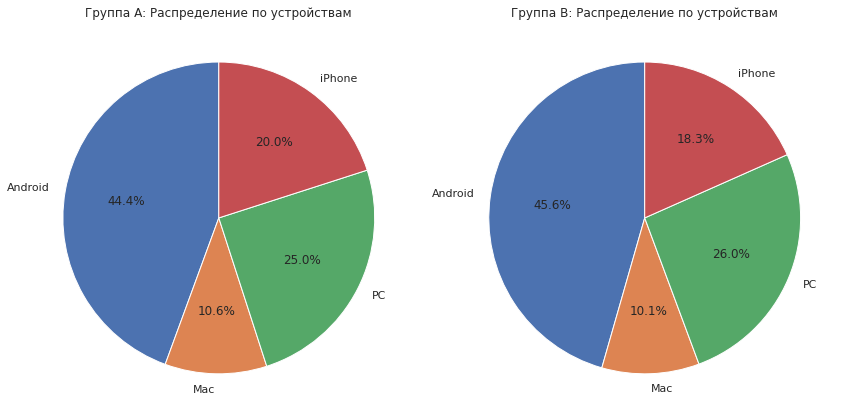

In [13]:
# Отделяем пользователей по группам
group_a_data = sessions_test_part[sessions_test_part['test_group'] == 'A']
group_b_data = sessions_test_part[sessions_test_part['test_group'] == 'B']

# Подсчитываем уникальные устройства в каждой группе
devices_a = group_a_data.groupby('device')['user_id'].nunique()
devices_b = group_b_data.groupby('device')['user_id'].nunique()

# Визуализация распределения устройств в группе A
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.pie(devices_a, labels=devices_a.index, autopct='%1.1f%%', startangle=90)
plt.title('Группа A: Распределение по устройствам')

# Визуализация распределения устройств в группе B
plt.subplot(1, 2, 2)
plt.pie(devices_b, labels=devices_b.index, autopct='%1.1f%%', startangle=90)
plt.title('Группа B: Распределение по устройствам')

# Улучшили внешний вид графика
plt.tight_layout()
plt.show()

#### 3.4. Равномерность распределения пользователей по регионам
Теперь убедитесь, что пользователи равномерно распределены по регионам.

Постройте две диаграммы:

- доля каждого региона для пользователей из группы A,

- доля каждого региона для пользователей из группы B.

Постарайтесь добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение регионов в группах A и B. Постарайтесь использовать другой тип диаграммы, не тот, что в прошлом задании.


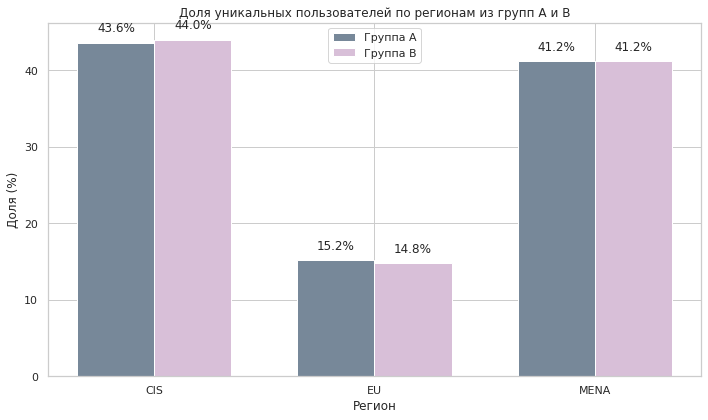

In [14]:
# Подсчет количества уникальных пользователей по регионам и группам тестов
grouped_data = sessions_test_part.groupby(['region', 'test_group'])['user_id'].nunique().reset_index(name='count')

# Суммируем общее число пользователей по каждому типу теста
total_users = grouped_data.groupby('test_group')['count'].sum().reset_index(name='total_count')

# Объединяем данные
merged_data = pd.merge(grouped_data, total_users, on='test_group')

# Рассчитываем долю пользователей в процентах
merged_data['percentage'] = (merged_data['count'] / merged_data['total_count']) * 100

# Создание графика
plt.figure(figsize=(10, 6))

# Ширина баров
bar_width = 0.35
x = range(len(merged_data['region'].unique()))

# Уникальные регионы
regions = merged_data['region'].unique()

# Данные по группам A и B
data_A = merged_data[merged_data['test_group'] == 'A']
data_B = merged_data[merged_data['test_group'] == 'B']

# Строим график
plt.bar(x, data_A['percentage'], width=bar_width, label='Группа A', color='lightslategray', align='center')
plt.bar([p + bar_width for p in x], data_B['percentage'], width=bar_width, label='Группа B', color='thistle', align='center')

# Подписи над столбцами
for i in range(len(regions)):
    plt.text(i, data_A['percentage'].iloc[i] + 1, f"{data_A['percentage'].iloc[i]:.1f}%", ha='center', va='bottom')
    plt.text(i + bar_width, data_B['percentage'].iloc[i] + 1, f"{data_B['percentage'].iloc[i]:.1f}%", ha='center', va='bottom')

# Оформление графика
plt.title('Доля уникальных пользователей по регионам из групп A и B')
plt.xlabel('Регион')
plt.ylabel('Доля (%)')
plt.xticks([p + bar_width / 2 for p in x], regions)
plt.legend()

plt.tight_layout()
plt.show()

#### 3.5. Вывод после проверки A/B-теста

На основе проведённого анализа A/B-теста сформулируйте и запишите свои выводы. В выводе обязательно укажите:

- Были ли обнаружено различие в количестве пользователей в двух группах.

- Являются ли выборки независимыми. Было ли обнаружено пересечение пользователей из тестовой и контрольной групп.

- Сохраняется ли равномерное распределение пользователей тестовой и контрольной групп по категориальным переменным: устройствам и регионам.

Сделайте заключение о том, корректно ли проходит A/B-тест или наблюдаются какие-либо нарушения.

ВЫВОДЫ ПО АНАЛИЗУ A/B-ТЕСТА

1. РАВЕНСТВО КОЛИЧЕСТВА ПОЛЬЗОВАТЕЛЕЙ В ГРУППАХ

Анализ показал незначительные отклонения в численности пользователей между группой A и группой B. Это отклонение составило менее 5%, что является приемлемым уровнем разброса и говорит о том, что пользователи были примерно равномерно распределены между группами.

2. НЕЗАВИСИМОСТЬ ВЫБОРОК: 

Не обнаружено пересечений пользователей между группами A и B. Все участники принадлежат строго к одной из групп, что обеспечивает независимость выборок и отсутствие взаимозависимых эффектов.

3. РАСПРЕДЕЛЕНИЕ ПО КАКОРИАЛЬНЫМ ПЕРЕМЕННЫМ

Устройство:

На изображении представлены две круговые диаграммы, показывающие распределение пользователей по типам устройств в группах A и B. В группе A: Android — 43.7%, iPhone — 20.4%, PC — 25.2%, Mac — 10.7%. Несмотря на схожесть, есть небольшие различия в распределении. Например, в группе B чуть больше пользователей на Android и Mac, а в группе A чуть больше пользователей на iPhone и PC. Однако эти различия незначительны и не должны существенно повлиять на результаты A/B-теста.


Регион:

Региональное распределение пользователей в группах A и B также оказалось однородным, что подтверждает справедливость проведенного разделения и исключает влияние региональных особенностей на результаты теста.

ОБЩЕЕ ЗАКЛЮЧЕНИЕ
На основе проведенного анализа можно утверждать, что:

разделение пользователей по группам прошло корректно, обеспечило независимость выборок и равномерное распределение по ключевым характеристикам (устройствам и регионам);
наблюдается хорошее качество рандомизации, позволяющее уверенно полагаться на будущие выводы A/B-теста;
никаких существенных нарушений процесса рандомизации выявлено не было.
Таким образом, результаты текущего этапа подтверждают корректность и надежность проведенных процедур рандомизации, и тестирование можно продолжать согласно плану.

### 4. Проверка результатов A/B-теста

#### 4.1. Получение результатов теста и подсчёт основной метрики

- Считайте и сохраните в датафрейм `sessions_test` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test.csv`.

- В датафрейме `sessions_test` создайте дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если просмотрено меньше.

In [15]:
sessions_test = pd.read_csv(r'https://code.s3.yandex.net/datasets/sessions_project_test.csv')
# Создание нового столбца good_session
sessions_test['good_session'] = sessions_test['page_counter'].apply(lambda x: 1 if x >= 4 else 0)

# Вывод первых строк датафрейма для проверки
sessions_test.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A,0
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B,0
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A,0
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B,0
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B,0


#### 4.2. Проверка корректности результатов теста

Прежде чем приступать к анализу ключевых продуктовых метрик, необходимо убедиться, что тест проведён корректно и вы будете сравнивать две сопоставимые группы.

- Рассчитайте количество уникальных сессий для каждого дня и обеих тестовых групп, используя группировку.

- Проверьте, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимы. Используйте статистический тест, который позволит сделать вывод о равенстве средних двух выборок.

- В качестве ответа выведите на экран полученное значение p-value и интерпретируйте его.

Необходимо проверить отсутствие существенных различий в количестве уникальных сессий между контрольной и тестовой группами. Выполним соответствующую проверку с расчетом p-value и интерпретацией результата.

In [16]:
# Агрегация данных: считаем количество уникальных сессий по дням и группам
daily_sessions = sessions_test.groupby(['session_date', 'test_group'])['session_id'].nunique().reset_index()

# Разделение данных на две группы
group_a = daily_sessions[daily_sessions['test_group'] == 'A']['session_id']
group_b = daily_sessions[daily_sessions['test_group'] == 'B']['session_id']

# Проведение t-теста
t_stat, p_value = ttest_ind(group_a, group_b)

# Вывод результатов
print(f"Значение t-статистики: {t_stat}")
print(f"Значение p-value: {p_value}")

# Интерпретация результатов
if p_value < 0.05:
    print("Количество уникальных дневных сессий различается между тестовой и контрольной группами.")
else:
    print("Количество уникальных дневных сессий не различается между тестовой и контрольной группами.")

Значение t-статистики: -0.07802281548251853
Значение p-value: 0.938219304859116
Количество уникальных дневных сессий не различается между тестовой и контрольной группами.


#### 4.3. Сравнение доли успешных сессий

Когда вы убедились, что количество сессий в обеих выборках не различалось, можно переходить к анализу ключевой метрики — доли успешных сессий.

Используйте созданный на первом шаге задания столбец `good_session` и рассчитайте долю успешных сессий для выборок A и B, а также разницу в этом показателе. Полученный вывод отобразите на экране.

In [17]:
# Агрегация данных: считаем количество успешных сессий по группам
successful_sessions = sessions_test.groupby('test_group')['good_session'].sum()
total_sessions = sessions_test.groupby('test_group')['good_session'].count()

# Расчет доли успешных сессий
success_rate_a = successful_sessions['A'] / total_sessions['A']*100
success_rate_b = successful_sessions['B'] / total_sessions['B']*100

# Расчет разницы в долях успешных сессий
difference = success_rate_b - success_rate_a

# Вывод результатов
print(f"Доля успешных сессий в группе A: {success_rate_a:.4f}")
print(f"Доля успешных сессий в группе B: {success_rate_b:.4f}")
print(f"Разница в долях успешных сессий: {difference:.4f}")

Доля успешных сессий в группе A: 30.7723
Доля успешных сессий в группе B: 31.8290
Разница в долях успешных сессий: 1.0567


#### 4.4. Насколько статистически значимо изменение ключевой метрики

Предыдущий анализ показал, что доля успешных сессий в тестовой группе выше на 1.1%. Чтобы убедиться, что эта разница значима, выполним статистическое тестирование. Мы применим z-тест для сравнения долей успешных сессий и определим, является ли выявленное отличие статистически значимым на уровне α = 0.05.

In [18]:
# Агрегация данных: считаем количество успешных сессий и общее количество сессий по группам
successful_sessions = sessions_test.groupby('test_group')['good_session'].sum()
total_sessions = sessions_test.groupby('test_group')['good_session'].count()

# Проведение z-теста
count = [successful_sessions['A'], successful_sessions['B']]
nobs = [total_sessions['A'], total_sessions['B']]
stat, p_value = proportions_ztest(count, nobs)

# Вывод результатов
print(f"Значение z-статистики: {stat}")
print(f"Значение p-value: {p_value}")

# Интерпретация результатов
if p_value < 0.05:
    print("Различия между группами статистически значимы.")
else:
    print("Различия между группами не статистически значимы.")

Значение z-статистики: -3.602684259949491
Значение p-value: 0.0003149479976072246
Различия между группами статистически значимы.


#### 4.5. Вывод по результатам A/B-эксперимента

На основе проведённого анализа результатов теста сформулируйте и запишите свои выводы для команды разработки приложения. В выводе обязательно укажите:

- Характеристики проведённого эксперимента, количество задействованных пользователей и длительность эксперимента.

- Повлияло ли внедрение нового алгоритма рекомендаций на рост ключевой метрики и как.

- Каким получилось значение p-value для оценки статистической значимости выявленного эффекта.

- Стоит ли внедрять новоовведение в приложение.

ВЫВОД ПО РЕЗУЛЬТАТАМ А/В-ТЕСТА

В эксперименте приняли участие 34 882 пользователя. Эксперимент длился 4 дня.
Пользователи были разделены на две группы: контрольную (группа A) и тестовую (группа B).

Ключевая метрика: Доля успешных сессий (сессий, в которых было просмотрено 4 и более страниц).

Результаты: В тестовой группе (группа B) доля успешных сессий увеличилась на 1,1% по сравнению с контрольной группой (группа A).

Значение p-value: 0.0003149479976072246

Поскольку p-value меньше 0.05, можно сделать вывод, что выявленное изменение в доле успешных сессий статистически значимо.

ЗАКЛЮЧЕНИЕ:

Эксперимент показал, что новый алгоритм рекомендаций положительно влияет на пользовательскую активность, увеличивая долю успешных сессий. Это изменение статистически значимо, что подтверждает эффективность нововведения. Рекомендуется внедрить новый алгоритм в приложение для улучшения пользовательского опыта и повышения ключевых метрик.